In [28]:
import torch

In [29]:
conv = torch.nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [30]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [31]:
from torchvision import datasets
from torchvision import transforms

data_path= '../dataset'
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]),
)

cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]),
)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [33]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.shape, img.unsqueeze(0).shape, output.shape

(torch.Size([3, 32, 32]),
 torch.Size([1, 3, 32, 32]),
 torch.Size([1, 16, 30, 30]))

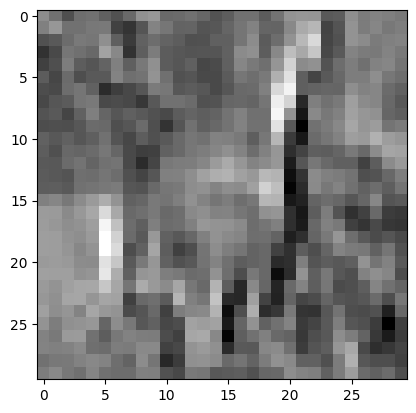

In [34]:
import matplotlib.pyplot as plt

plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


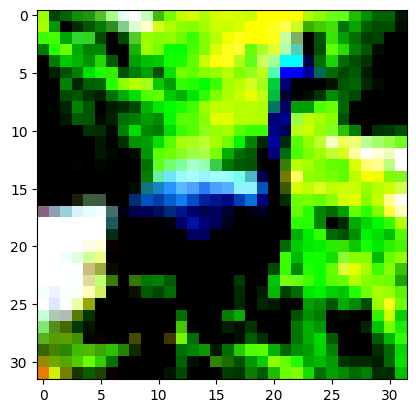

torch.Size([30, 30])

In [35]:
plt.imshow(img.detach().permute(1,2,0))
plt.show()

output[0,0].shape

In [37]:
# before padding, output shape: torch.Size([1, 16, 30, 30])
conv = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [39]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

In [41]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

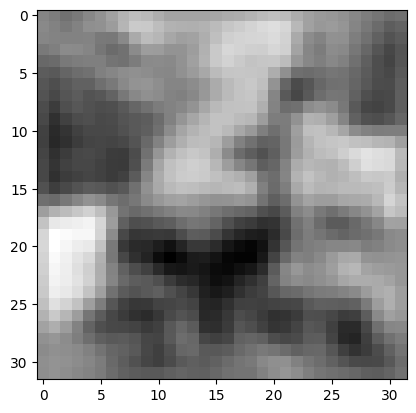

In [44]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

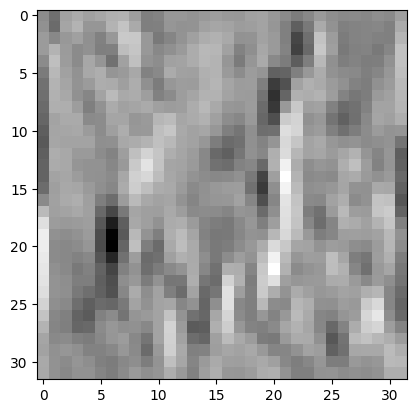

In [45]:
conv = torch.nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0]
    ])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

In [47]:
pool = torch.nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [48]:
import torch
from torch import nn

model = torch.nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),

    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32,2)
)

In [50]:
output = model(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [53]:
import torch.nn.functional as F 

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0634,  0.0719]], grad_fn=<AddmmBackward0>)

In [58]:
import datetime

def train_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(         
       datetime.datetime.now(), epoch,         
       loss_train / len(train_loader)))

In [61]:
from torch import optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

train_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2024-03-12 15:16:30.687509 Epoch 1, Training loss 0.5643786799376178
2024-03-12 15:16:50.752105 Epoch 10, Training loss 0.32853695256694865
2024-03-12 15:17:13.430170 Epoch 20, Training loss 0.2965644488858569
2024-03-12 15:17:36.219687 Epoch 30, Training loss 0.26960844798072886
2024-03-12 15:18:00.138857 Epoch 40, Training loss 0.2486938649112252
2024-03-12 15:18:26.650353 Epoch 50, Training loss 0.2318007345696923
2024-03-12 15:18:53.134448 Epoch 60, Training loss 0.21605107321101388
2024-03-12 15:19:17.823381 Epoch 70, Training loss 0.19901176577635632
2024-03-12 15:19:42.064753 Epoch 80, Training loss 0.18368575185727162
2024-03-12 15:20:06.372116 Epoch 90, Training loss 0.17365955532925903
2024-03-12 15:20:30.705631 Epoch 100, Training loss 0.15949679042693157


In [63]:
data_path = './'
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [73]:
# 非原地操作
a = torch.tensor([1, 2, 3], requires_grad=True, dtype=float)
b = torch.tensor([4, 5, 6], requires_grad=True, dtype=float)
c = a + b
d = c.sum()
d.backward()

print(a.grad)  # 输出: tensor([1, 1, 1])
print(b.grad)  # 输出: tensor([1, 1, 1])


a_clone = a.clone()
a_clone += b

c = a_clone.sum()
c.backward()

#print(a.grad)  # 输出: None
#print(a_clone.grad)  # 输出: tensor([1, 1, 1])

# 原地操作
a = torch.tensor([1, 2, 3], requires_grad=True, dtype=float)
b = torch.tensor([4, 5, 6], requires_grad=True, dtype=float)
a += b
c = a.sum()
c.backward()

print(a.grad)  # 输出: tensor([2, 2, 2])

tensor([1., 1., 1.], dtype=torch.float64)
tensor([1., 1., 1.], dtype=torch.float64)


RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [71]:
with torch.no_grad():
    a += b

c = a.sum()
c.backward()

print(a.grad)  # 输出: tensor([1, 1, 1])


tensor([1., 1., 1.], dtype=torch.float64)


In [74]:
x = torch.tensor([1., 2.], requires_grad=True)
y = x * 2 # y作为计算图中间节点,保存了对x的引用
y.add_(1) # 原地修改y,但y节点保存的x.data已经被改变
z = y * y # 由于y节点的输入值已被修改,z节点无法正确计算梯度
z.backward()
print(x.grad) # 输出None,而非期望的[4., 8.]

RuntimeError: grad can be implicitly created only for scalar outputs

In [78]:
import re

help(re.split)

'af'.split('')

Help on function split in module re:

split(pattern, string, maxsplit=0, flags=0)
    Split the source string by the occurrences of the pattern,
    returning a list containing the resulting substrings.  If
    capturing parentheses are used in pattern, then the text of all
    groups in the pattern are also returned as part of the resulting
    list.  If maxsplit is nonzero, at most maxsplit splits occur,
    and the remainder of the string is returned as the final element
    of the list.



ValueError: empty separator

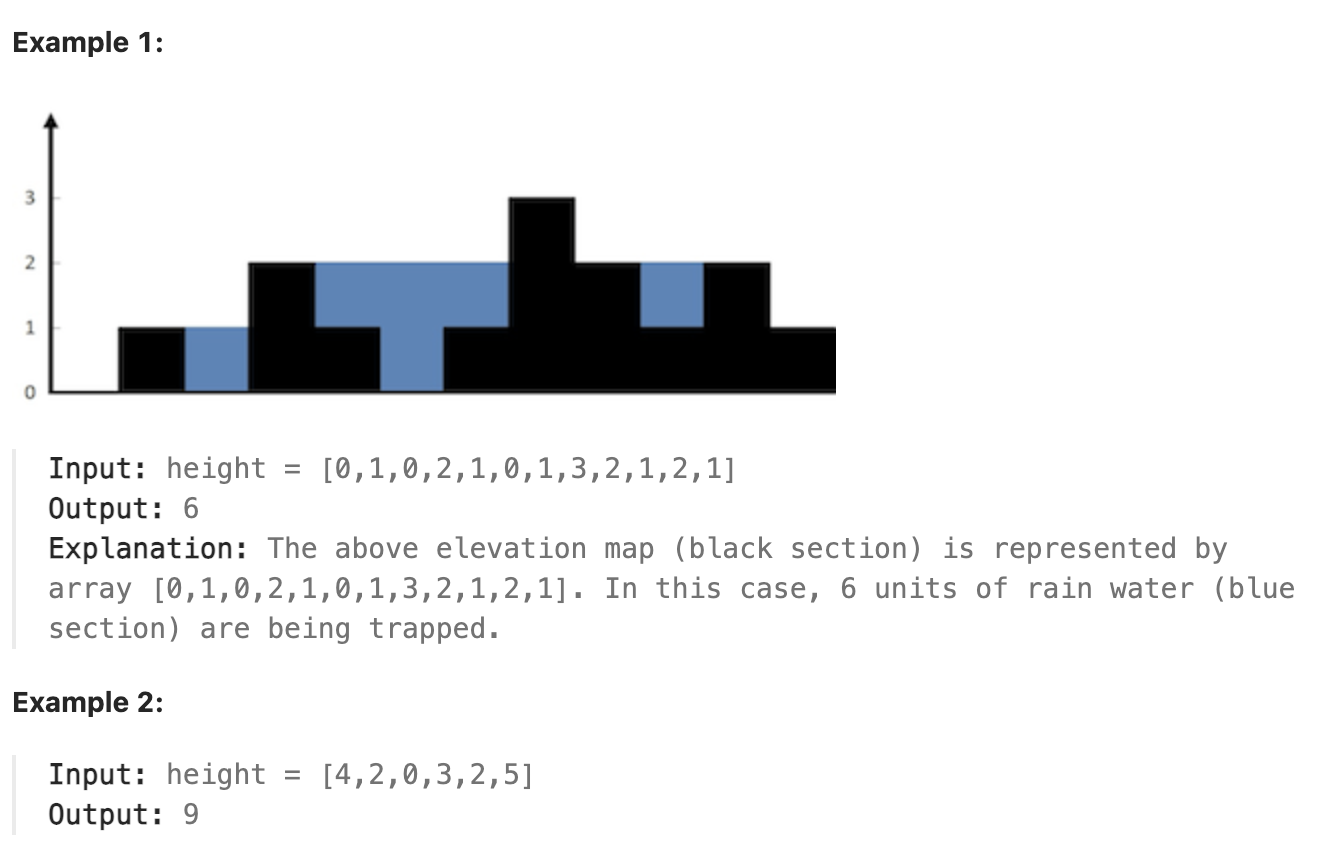

In [ ]:
class Solution:

    def trap(self, height: List[int]) -> int:
        n = len(height)
        if < 2:
            return 0

        r = 0
        l = 0
        result = 0
        find_r = False
        find_l = False
        while r < n and l < n:
            if find_r == False and height[r] > 0:
                find_r = True
                l = r + 1
                continue

            if find_l == False and height[l]
